# Zonal Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from matplotlib import cm, colors

import pylandstats as pls

# let us use a custom colormap
custom_cmap = colors.ListedColormap([
    (0, 0, 0, 0),
    (0.6, 0, 0, 1),
    (.95, .9, .75, 1),
], N=3)

Landscapes tend to be heterogeneous and complex and therefore reducing such information to a single scalar value for all the landscape often leads to metric values that are hard to interpret. It might thus be helpful to decompose the landscape into a set of zones of interest and compute the metrics for each zone separatedly. Such approach to GIS is often referred to as zonal analysis. The PyLandStats library features three classes that might be used to that end: the more generic `ZonalAnalysis`, `BufferAnalysis` and `ZonalGridAnalysis`.

Consider the following landscape of the Canton of Vaud, Switzerland:

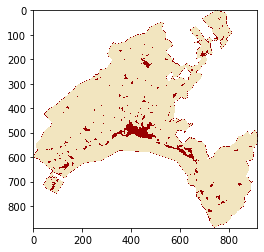

In [2]:
URBAN_CLASS_VAL = 1
input_filepath = '../data/clc/vaud_g100_clc00_V18_5.tif'

with rasterio.open(input_filepath) as src:
    plt.imshow(src.read(1), cmap=custom_cmap)

Red and cream pixels represent urban and natural land uses respectively. At the center of our Landscape stands a large urban patch, which corresponds to the agglomeration of Lausanne.

Landscape metrics are very sensitive to the spatial extent of the map. Therefore, when evaluating the landscape patterns of the agglomeration of Lausanne, the computed values for the metrics would strongly depend on how such agglomeration extent is defined. In order to overcome such issue, landscape studies often study how metrics vary for a set of spatial extents along the urban-rural gradient.

## Zonal analysis

The `ZonalAnalysis` class of PyLandStats serves to compute the landscape metrics over any set of zones, which can be defined by means of raster or vector geometries.

### Using raster masks to define zones

The zones can be defined as NumPy boolean arrays of the same shape of the landscape of interest. For instance, in order to compute the metrics over a set of rectangular transects, let us define three transects of 300x200 cells (30x20km) that horizontally traverse our landscape at the latitude of Lausanne:

In [3]:
with rasterio.open(input_filepath) as src:
    base_mask_arr = np.full(src.shape,  False)

masks = []
transect_len = 300
for transect_start in range(0, 900, transect_len):
    mask_arr = np.copy(base_mask_arr)
    mask_arr[400:600,transect_start:transect_start+transect_len] = True
    masks.append(mask_arr)    

This is how the mask of each transect looks:

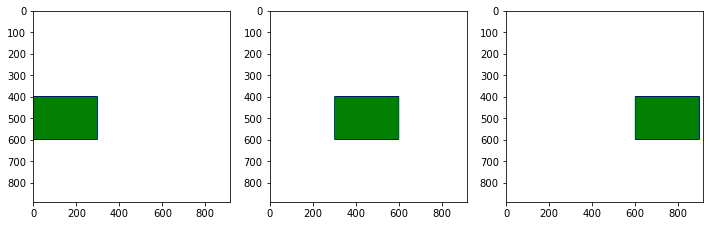

In [4]:
num_subplots = len(masks)
fig = plt.figure(figsize=(num_subplots * 4, 4))
# better colormap to plot mask arrays
mask_cmap = plt.get_cmap('ocean_r')

for i in range(num_subplots):
    ax = fig.add_subplot(1, num_subplots, i + 1)
    ax.imshow(masks[i], cmap=mask_cmap)

We will now use the `ZonalAnalysis` class with the list of mask arrays (corresponding to the transects) that we have constructed above. We can use the keyword argument `attribute_values` to map an identifying value or label to each of our landscapes. 

Here we will use strings that denote that each landscape corresponds to the transect from kilometers 0 to 30, 30 to 60 and 60 to 90 respectively. But we could have used any other list-like argument as long as it is consistent with the number of mask arrays provided through the `masks` argument.

In [5]:
za = pls.ZonalAnalysis(input_filepath,
                       masks=masks,
                       attribute_values=['0-30', '30-60', '60-90'])

The `ZonalAnalysis` instance will automatically generate the three landscapes of interest (one for each transect) by masking the pixels of the input raster, which can be visualized by means of the `plot_landscapes` method as in:

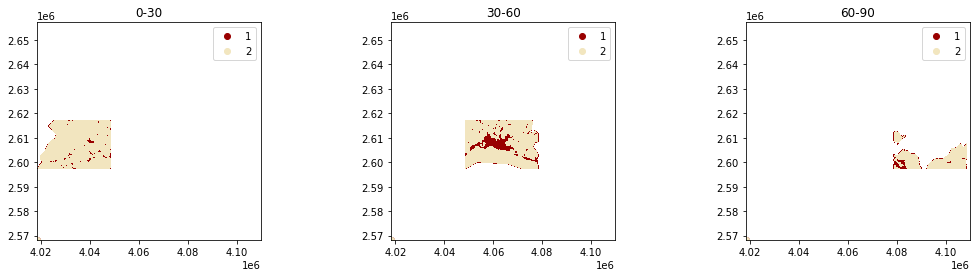

In [6]:
fig = za.plot_landscapes(cmap=custom_cmap)

And we can now compute and plot the landscape metrics for each of the transect landscapes.

Like `SpatioTemporalAnalysis`, `ZonalAnalysis` only supports class and landscape-level metrics, which again, can be computed by means of its methods `compute_class_metrics_df` and `compute_landscape_metrics_df` respectively, e.g.:

In [7]:
za.compute_class_metrics_df()

metric                      total_area  proportion_of_landscape  \
class_val attribute_values                                        
1         0-30                  2641.0                 5.076796   
          30-60                 9577.0                17.696515   
          60-90                 1761.0                 9.272813   
2         0-30                 49380.0                94.923204   
          30-60                44541.0                82.303485   
          60-90                17230.0                90.727187   

metric                      number_of_patches  patch_density  \
class_val attribute_values                                     
1         0-30                           37.0       0.071125   
          30-60                          40.0       0.073913   
          60-90                           9.0       0.047391   
2         0-30                            2.0       0.003845   
          30-60                           6.0       0.011087   
          60-90                           6.0       0.031594   

metric                      largest_patch_index  total_edge  edge_density  \
class_val attribute_values                                                  
1         0-30                         0.707407    216700.0      4.165625   
          30-60                       12.280572    370500.0      6.846151   
          60-90                        6.908536     71900.0      3.786004   
2         0-30                        94.919359    216700.0      4.165625   
          30-60                       81.885879    370500.0      6.846151   
          60-90                       53.219946     71900.0      3.786004   

metric                      landscape_shape_index  effective_mesh_size  \
class_val attribute_values                                               
1         0-30                          10.796117             7.814171   
          30-60                          9.637755           831.454692   
          60-90                          4.714286            92.989679   
2         0-30                           3.611236         46869.281406   
          30-60                          5.661939         36288.169130   
          60-90                          3.756654          6891.825918   

metric                           area_mn  ...  fractal_dimension_md  \
class_val attribute_values                ...                         
1         0-30                 71.378378  ...              1.087145   
          30-60               239.425000  ...              1.081846   
          60-90               195.666667  ...              1.066913   
2         0-30              24690.000000  ...              1.070064   
          30-60              7423.500000  ...              1.051841   
          60-90              2871.666667  ...              1.077970   

metric                      fractal_dimension_ra  fractal_dimension_sd  \
class_val attribute_values                                               
1         0-30                          0.162565              0.042599   
          30-60                         0.167805              0.037093   
          60-90                         0.129875              0.042493   
2         0-30                          0.116342              0.058171   
          30-60                         0.171006              0.059365   
          60-90                         0.098317              0.032974   

metric                      fractal_dimension_cv  \
class_val attribute_values                         
1         0-30                          3.929864   
          30-60                         3.429716   
          60-90                         3.964898   
2         0-30                          5.436212   
          30-60                         5.594315   
          60-90                         3.082669   

metric                      euclidean_nearest_neighbor_mn  \
class_val attribute_values                                  
1         0-30                         

Likewise `SpatioTemporalAnalysis`, if we want to compute the metrics data frame only for a subset of metrics or classes, or customize how the metrics are computed, we must pass the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df`, as in:
<a id='customizing-zonal-analysis'></a>

In [8]:
metrics=['proportion_of_landscape', 'edge_density', 'fractal_dimension_am']
classes=[URBAN_CLASS_VAL]
metrics_kws={
    'proportion_of_landscape': {'percent': False },
    'edge_density': {'count_boundary': True}
}
za.compute_class_metrics_df(
    metrics=metrics, classes=[1], metrics_kws=metrics_kws)

metric                      proportion_of_landscape  edge_density  \
class_val attribute_values                                          
1         0-30                             0.050768      4.275197   
          30-60                            0.176965      6.981041   
          60-90                            0.092728      4.170397   

metric                      fractal_dimension_am  
class_val attribute_values                        
1         0-30                          1.105046  
          30-60                         1.148991  
          60-90                         1.118274

On the other hand, the `plot_metric` method of `ZonalAnalysis` will plot the value of a given metric for each of the buffered landscapes:

<AxesSubplot:ylabel='PLAND'>

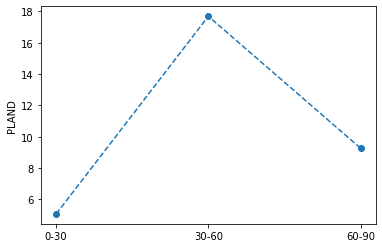

In [9]:
za.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

Note that the values that we pass to `attribute_values` when initializing the `ZonalAnalysis` are used within the metric dataframes and plot labels.

In order to visualize such information in space, the zonal statistics can be computed in the form of a two-dimensional array with the `compute_zonal_statistics_arr` method as in:

In [10]:
zonal_statistics_arr = za.compute_zonal_statistics_arr(
    'proportion_of_landscape', class_val=URBAN_CLASS_VAL)

which returns an array of the same form as the input landscape.

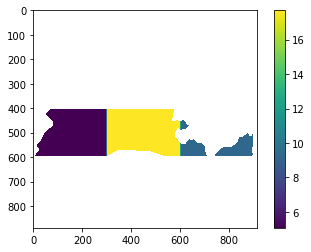

In [11]:
plt.imshow(zonal_statistics_arr)
plt.colorbar()

We can see that the highest proportion of urban land cover is found in the central transect, which actually corresponds to the most urbanized parts of Lausanne's agglomeration.

A zonal statistics array can be dumped into a GeoTiff raster file by means of the the `dst_filepath` argument of `compute_zonal_statistics_arr` as in:

In [12]:
_ = za.compute_zonal_statistics_arr('proportion_of_landscape',
                                    class_val=URBAN_CLASS_VAL,
                                    dst_filepath='pland-transects.tif')

### Using vector geometries to define zones

We can also use vector geometries to define zones. For

In [13]:
import geopandas as gpd

dem_filepath = '../data/dem/dem.shp'

za = pls.ZonalAnalysis(input_filepath,
                       masks=dem_filepath,
                       masks_index_col='elev')

We can then compute data frames of metrics, e.g.:

In [14]:
class_metrics_df = za.compute_class_metrics_df(metrics=['proportion_of_landscape'])
class_metrics_df

metric            proportion_of_landscape
class_val elev                           
1         500.0                 10.035316
          700.0                  7.295199
          900.0                  0.000000
          1100.0                 0.000000
          1300.0                 0.000000
          1500.0                 0.000000
2         500.0                 89.964684
          700.0                 92.704801
          900.0                100.000000
          1100.0               100.000000
          1300.0               100.000000
          1500.0               100.000000

In this case we see how the proportion of urbanized landscape (class `1`) becomes zero at highest altitudes.

## Buffer Analysis

In line with the classic concentric models of location and land use, we are often interested in evaluate how the landscape patterns change as we move away from the urban center. To that end, PyLandStats features the `BufferAnalysis` class (which inherits from the `ZonalAnalysis` class), which defines a series of spatial extents for our landscape based on buffers of increasing distances around our feature of interest - in this example, the agglomeration of Lausanne.

### From Point

We might define a given coordinate as the center of our region of interest (in this example, the center of Lausanne) and a series of buffer distances around that point:

In [15]:
from shapely.geometry import Point

# latitude and longitude of the center of Lausanne according to OpenStreetMap
base_mask = Point(6.6327025, 46.5218269)
base_mask_crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

# buffer distances (in meters)
buffer_dists = [10000, 15000, 20000]

then, we can use the `BufferAnalysis` class of Pylandstats as in (note that we need to provide the CRS of the geometry - in this example, the coordinate point):

In [16]:
ba = pls.BufferAnalysis(input_filepath,
                        base_mask,
                        buffer_dists,
                        base_mask_crs=base_mask_crs)

The `BufferAnalysis` instance will automatically generate the three landscapes of interest (one for each buffer distance) by masking the pixels of the input raster:

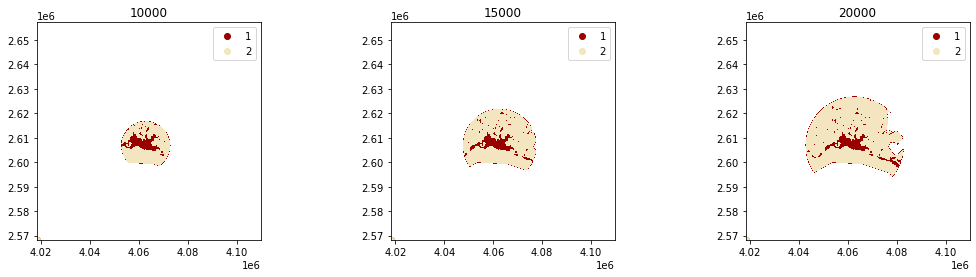

In [17]:
fig = ba.plot_landscapes(cmap=custom_cmap)

Likewise `ZonalAnalysis`, we can compute the landscap metrics for each buffer distance with the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods, e.g.:

In [18]:
ba.compute_class_metrics_df()

metric                  total_area  proportion_of_landscape  \
class_val buffer_dists                                        
1         10000             7261.0                24.964758   
          15000             9630.0                16.710627   
          20000            12149.0                13.347616   
2         10000            21824.0                75.035242   
          15000            47998.0                83.289373   
          20000            78871.0                86.652384   

metric                  number_of_patches  patch_density  largest_patch_index  \
class_val buffer_dists                                                          
1         10000                      20.0       0.068764            21.547189   
          15000                      46.0       0.079822            11.532588   
          20000                      76.0       0.083498             7.301692   
2         10000                       4.0       0.013753            74.361355   
          15000                       4.0       0.006941            82.949261   
          20000                       5.0       0.005493            86.315096   

metric                  total_edge  edge_density  landscape_shape_index  \
class_val buffer_dists                                                    
1         10000           223900.0      7.698126               6.742690   
          15000           395200.0      6.857777              10.147208   
          20000           565200.0      6.209624              12.963801   
2         10000           223900.0      7.698126               4.966216   
          15000           395200.0      6.857777               5.794989   
          20000           565200.0      6.209624               6.631673   

metric                  effective_mesh_size       area_mn  ...  \
class_val buffer_dists                                     ...   
1         10000                 1353.370913    363.050000  ...   
          15000                  774.307351    209.347826  ...   
          20000                  515.419677    159.855263  ...   
2         10000                16083.663125   5456.000000  ...   
          15000                39651.804019  11999.500000  ...   
          20000                67812.981685  15774.200000  ...   

metric                  fractal_dimension_md  fractal_dimension_ra  \
class_val buffer_dists                                               
1         10000                     1.083177              0.163172   
          15000                     1.079439              0.141302   
          20000                     1.082422              0.167805   
2         10000                     1.064530              0.134831   
          15000                     1.064530              0.145607   
          20000                     1.087755              0.170269   

metric                  fractal_dimension_sd  fractal_dimension_cv  \
class_val buffer_dists                                               
1         10000                     0.043469              4.026701   
          15000                     0.030989              2.855440   
          20000                     0.034473              3.189557   
2         10000                     0.053805              4.982272   
          15000                     0.057990              5.356493   
          20000                     0.058537              5.409182   

metric                  euclidean_nearest_neighbor_mn  \
class_val buffer_dists                                  
1         10000                            633.890519   
          15000                            768.449416   
          20000                            825.643072   
2         10000                            211.803399   
          15000                            223.606798   
          20000                            229.442719   

metric                  euclidean_nearest_neighbor_am  \
class_val buffer_dists                                  
1         10000        

Note that the data frames for `BufferAnalysis`, likewise those of `SpatioTemporalAnalysis` or `ZonalAnalysis` (see [above](#customizing-zonal-analysis)) can be customized via by passing the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods.

The `plot_metric` method of `BufferAnalysis` will plot the value of a given metric for each of the buffered landscapes:

<AxesSubplot:ylabel='PLAND'>

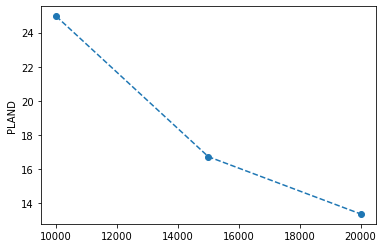

In [19]:
ba.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

The specific plot above shows how the proportion of landscape (y-axis) occupied by urban land uses diminishes with the buffer distance (x-axis) around the feature of interest (i.e., the city center of Lausanne).

To examine more closely how landscape patterns change as we move along the urban-rural gradient, we might actually want to compute the metrics for each of the buffer rings that lie within each pair of increasing buffer distances. For instance, for the buffer distances considered in this example (i.e., 10000, 15000 and 20000), we would like to compute the metrics for the buffer rings that go from 0 to 10000m, 10000-15000m and 15000-20000m around the center of Lausanne).

To that end, we might pass the argument `buffer_rings=True` when instantiating `BufferAnalysis` as in:

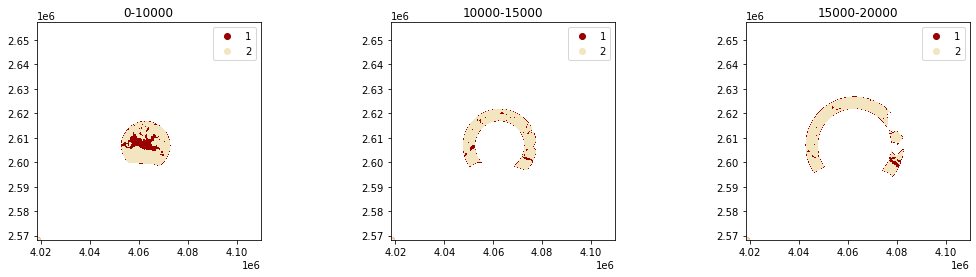

In [20]:
ba = pls.BufferAnalysis(input_filepath,
                        base_mask,
                        buffer_dists,
                        buffer_rings=True,
                        base_mask_crs=base_mask_crs)
fig = ba.plot_landscapes(cmap=custom_cmap)

In [21]:
ba.compute_class_metrics_df()

metric                  total_area  proportion_of_landscape  \
class_val buffer_dists                                        
1         0-10000           7261.0                24.964758   
          10000-15000       2369.0                 8.299758   
          15000-20000       2519.0                 7.543723   
2         0-10000          21824.0                75.035242   
          10000-15000      26174.0                91.700242   
          15000-20000      30873.0                92.456277   

metric                  number_of_patches  patch_density  largest_patch_index  \
class_val buffer_dists                                                          
1         0-10000                    20.0       0.068764            21.547189   
          10000-15000                37.0       0.129629             1.685177   
          15000-20000                37.0       0.110805             3.111524   
2         0-10000                     4.0       0.013753            74.361355   
          10000-15000                 3.0       0.010510            83.628210   
          15000-20000                 8.0       0.023958            76.117034   

metric                  total_edge  edge_density  landscape_shape_index  \
class_val buffer_dists                                                    
1         0-10000         223900.0      7.698126               6.742690   
          10000-15000     168600.0      5.906877               9.142857   
          15000-20000     169100.0      5.064087               8.990099   
2         0-10000         223900.0      7.698126               4.966216   
          10000-15000     168600.0      5.906877               5.015432   
          15000-20000     169100.0      5.064087               5.488636   

metric                  effective_mesh_size      area_mn  ...  \
class_val buffer_dists                                    ...   
1         0-10000               1353.370913   363.050000  ...   
          10000-15000             17.513050    64.027027  ...   
          15000-20000             36.183128    68.081081  ...   
2         0-10000              16083.663125  5456.000000  ...   
          10000-15000          20147.549662  8724.666667  ...   
          15000-20000          19637.585919  3859.125000  ...   

metric                  fractal_dimension_md  fractal_dimension_ra  \
class_val buffer_dists                                               
1         0-10000                   1.083177              0.163172   
          10000-15000               1.069990              0.123043   
          15000-20000               1.075960              0.141466   
2         0-10000                   1.064530              0.134831   
          10000-15000               1.042036              0.134779   
          15000-20000               1.065869              0.136933   

metric                  fractal_dimension_sd  fractal_dimension_cv  \
class_val buffer_dists                                               
1         0-10000                   0.043469              4.026701   
          10000-15000               0.028939              2.693334   
          15000-20000               0.035712              3.334076   
2         0-10000                   0.053805              4.982272   
          10000-15000               0.060481              5.612860   
          15000-20000               0.044375              4.135961   

metric                  euclidean_nearest_neighbor_mn  \
class_val buffer_dists                                  
1         0-10000                          633.890519   
          10000-15000                     1016.193308   
          15000-20000                      933.734139   
2         0-10000                          211.803399   
          10000-15000                      223.606798   
          15000-20000                      410.484861   

metric                  euclidean_nearest_neighbor_am  \
class_val buffer_dists                                  
1         0-10000              

<AxesSubplot:ylabel='PLAND'>

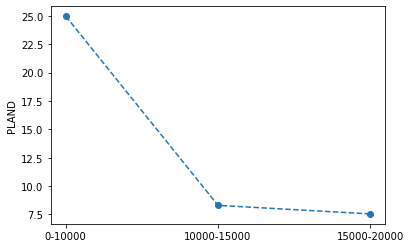

In [22]:
ba.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

Again, the zonal statistics of a metric can be represented in space with of the `compute_zonal_statistics_arr` method:

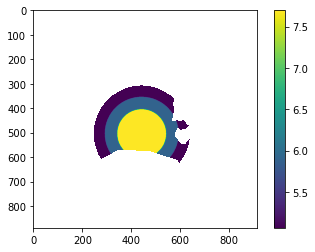

In [23]:
zonal_statistics_arr = ba.compute_zonal_statistics_arr(
    'edge_density', class_val=URBAN_CLASS_VAL)
plt.imshow(zonal_statistics_arr)
plt.colorbar()

and further dump it to a raster file by providing the `dst_filepath` argument.

### From Polygon

We might as well build our buffer zones from polygon geometries such as administrative boundaries

<AxesSubplot:>

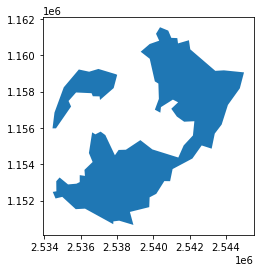

In [24]:
gdf = gpd.read_file('../data/gmb/g1a18.shp')
base_mask = gdf[gdf['GMDNAME'] == 'Lausanne']['geometry']
base_mask.plot()

Note that in this case, since we are working with a GeoSeries that has a CRS defined, we do not need to set it explicitly with the `base_mask_crs` argument.

In [25]:
base_mask.crs

<Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - Liechtenstein and Switzerland
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

Also note that since in this case our base mask from which we will define buffer zones is already a polygon. Therefore, we might want to start from smaller buffer distances, even from zero, so that we start computing the metrics for the region defined by the polygon itself (in our example, the administrative boundaries)

In [26]:
buffer_dists = [0, 10000, 20000]

In [27]:
ba = pls.BufferAnalysis(input_filepath, base_mask, buffer_dists)

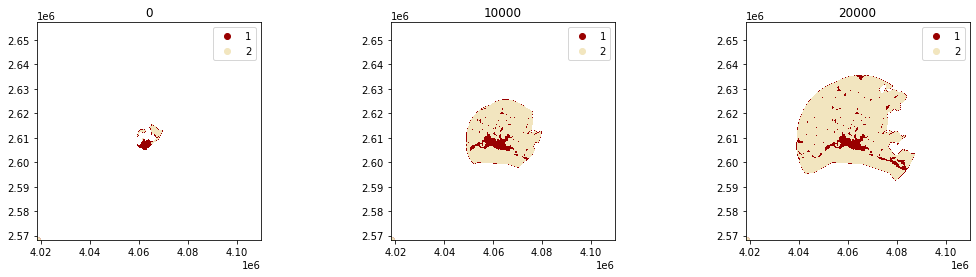

In [28]:
fig = ba.plot_landscapes(cmap=custom_cmap)

<AxesSubplot:ylabel='PLAND'>

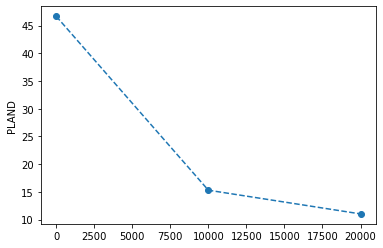

In [29]:
ba.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

## Zonal Grid Analysis

Another recurrent approach to zonal analysis is to decompose the landscape raster into a coarser grid and compute the landscape metrics for each zone cell. This is the purpose of the `ZonalGridAnalysis` class (which also inherits from `ZonalAnalysis`). We can instantiate it by providing the number of landscape pixels that we desire in each zone cell as in:

In [30]:
zone_pixel_width, zone_pixel_height = 50, 50

zga = pls.ZonalGridAnalysis(input_filepath,
                            zone_pixel_width=zone_pixel_width,
                            zone_pixel_height=zone_pixel_height)

Alternatively, we can instead define the number of zones that we desire in each dimension by means of the `num_zone_rows` and `num_zone_cols` keyword arguments of the initialization method.

The `ZonalGridAnalysis` class will automatically discard all the zone cells that have no data in the original raster. We can visualize the zonal grid (in random grid cell colors) as in:

<AxesSubplot:>

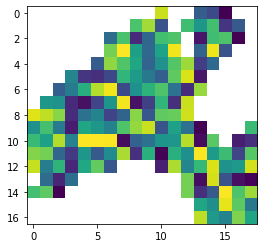

In [31]:
zga.plot_landscapes()

The `compute_class_metrics_df` and `compute_landscape_metrics_df` class operate exactly like in the other classes:

In [32]:
zga.compute_class_metrics_df(metrics=metrics, classes=[URBAN_CLASS_VAL])

metric              proportion_of_landscape  edge_density  \
class_val zones                                             
1         (0, 10)                  0.000000      0.000000   
          (0, 13)                  0.000000      0.000000   
          (0, 14)                  0.000000      0.000000   
          (0, 15)                  7.556368      7.190737   
          (1, 8)                   0.000000      0.000000   
...                                     ...           ...   
          (16, 13)                 0.000000      0.000000   
          (16, 14)                14.636406      8.059287   
          (16, 15)                 0.000000      0.000000   
          (16, 16)                 0.000000      0.000000   
          (16, 17)                 0.000000      0.000000   

metric              fractal_dimension_am  
class_val zones                           
1         (0, 10)                    NaN  
          (0, 13)                    NaN  
          (0, 14)                    NaN  
          (0, 15)               1.123904  
          (1, 8)                     NaN  
...                                  ...  
          (16, 13)                   NaN  
          (16, 14)              1.097453  
          (16, 15)                   NaN  
          (16, 16)                   NaN  
          (16, 17)                   NaN  

[182 rows x 3 columns]

Note that the data frames are now indexed by a list of tuples that correspond to the row, column location of each zone. The `NaN` rows thus correspond to zones with no pixels of `URBAN_CLASS_VAL`.

Like in the other zonal analysis classes, the zonal metrics van be represented in space by means of the `compute_zonal_statistics_arr` method. For instance, we can view the spatial distribution of the edge density at the landscape level as in:

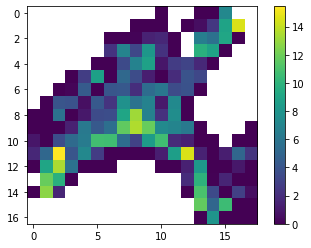

In [33]:
ed_zgs_arr = zga.compute_zonal_statistics_arr('edge_density')

plt.imshow(ed_zgs_arr)
plt.colorbar()

Again, we could provide a file path as the `dst_filepath` argument to dump such result into a raster file.

## See also

* [SpatioTemporalBufferAnalysis](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/04-spatiotemporal-buffer-analysis.ipynb)